Data Challenge : Can you predict the tide ?
Author : Oumeima EL GHARBI
Date : November 2022

# PART 2 : Regression predictive modelling

### Importing libraries

In [1]:
import pandas as pd
%reset -f

from functions import *
from surge_prediction_metric import *

import warnings
warnings.filterwarnings('ignore')
#warnings.filterwarnings(action="once")

from sklearn.neighbors import BallTree
from sklearn.multioutput import MultiOutputRegressor
from sklearn.kernel_ridge import KernelRidge
from xgboost import XGBRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor

%matplotlib inline
%autosave 300

Autosaving every 300 seconds


In [2]:
# Starting time
t0 = time()

baseline_error = 0.62 # SVR
seed = 42

#### Loading dataset

In [3]:
# load raw dataset
input_path = "./dataset/output/"
output_path = "./dataset/output/"

X_train_filename = "X_train.csv"
X_train_std_filename = "X_train_std.csv"
y_train_filename = "Y_train.csv"
X_val_filename = "X_val.csv"
X_val_std_filename = "X_val_std.csv"
y_val_filename = "Y_val_true.csv"
X_test_filename = "X_test.csv"
X_test_std_filename = "X_test_std.csv"

X_train_file = "{}{}".format(input_path, X_train_filename)
X_train_std_file = "{}{}".format(input_path, X_train_std_filename)
y_train_file = "{}{}".format(input_path, y_train_filename)
X_val_file = "{}{}".format(input_path, X_val_filename)
X_val_std_file = "{}{}".format(input_path, X_val_std_filename)
y_val_file = "{}{}".format(input_path, y_val_filename)
X_test_file = "{}{}".format(input_path, X_test_filename)
X_test_std_file = "{}{}".format(input_path, X_test_std_filename)

In [4]:
X_train = pd.read_csv(X_train_file)
X_train_std = pd.read_csv(X_train_std_file)
y_train = pd.read_csv(y_train_file)
X_val = pd.read_csv(X_val_file)
X_val_std = pd.read_csv(X_val_std_file)
y_val = pd.read_csv(y_val_file)
X_test = pd.read_csv(X_test_file)
X_test_std = pd.read_csv(X_test_std_file)

In [5]:
y_train_index = y_train["id_sequence"].tolist() # for Ball Tree
y_val_index = y_val["id_sequence"].tolist()
X_test_index = X_test["id_sequence"].tolist()

In [6]:
y_train

,id_sequence,surge1_t0,surge1_t1,surge1_t2,surge1_t3,surge1_t4,surge1_t5,surge1_t6,surge1_t7,surge1_t8,...,surge2_t0,surge2_t1,surge2_t2,surge2_t3,surge2_t4,surge2_t5,surge2_t6,surge2_t7,surge2_t8,surge2_t9
0,5569,0.013796,0.000389,0.315448,0.107643,-0.086755,0.010444,0.271876,0.375779,0.281932,...,0.432287,0.516110,0.105378,0.130525,0.440670,0.415523,0.138907,0.298171,0.122142,0.340082
1,2837,0.845017,0.556771,1.857229,0.372427,-0.914624,-0.304615,-0.411870,-0.750391,-0.626378,...,-1.302848,-1.042997,-1.084908,-0.783146,-0.992703,-1.571081,-1.403435,-1.017850,-0.313737,-0.598735
2,84,0.141160,0.198139,0.060720,-0.371649,0.265173,1.297496,1.860581,1.284089,1.274034,...,-0.045504,-0.028739,-0.347266,-0.975938,-0.908880,-1.219025,-1.260936,-1.068144,-0.732852,-0.196385
3,3659,-0.854294,-0.904569,-1.008472,-1.078857,-1.072154,-0.669950,-0.562696,-0.006314,0.245063,...,-5.762229,-4.194740,-5.720317,-4.286945,-4.999440,-4.949146,-4.270180,-4.714442,-3.993565,-3.054748
4,791,-0.814073,-0.807370,-0.961548,-1.162650,-1.380510,-1.112374,-0.626378,-0.123624,0.214898,...,-1.135202,-1.026232,-0.959174,-0.607117,-0.841822,-0.355649,-0.514912,-0.196385,-0.003592,-0.548441
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3914,3773,1.072932,1.049470,0.741114,0.707597,0.848368,0.499792,0.335559,1.485191,1.565631,...,0.465816,-0.540059,-0.674176,-0.975938,-0.489765,-0.372413,0.340082,0.599933,0.348464,0.314935
3915,5192,-0.187306,0.070775,0.241711,0.402593,0.945567,1.448322,0.868478,0.781334,0.204842,...,0.155671,0.063466,0.390376,0.507728,0.306553,0.365229,0.432287,0.088613,0.080231,-0.179620
3916,5227,-0.180603,-0.086755,0.754521,0.054016,0.975733,0.228304,0.224953,-0.190658,-0.328077,...,-0.070650,0.281406,-0.020357,0.197583,0.004790,0.490963,0.071849,0.843020,0.457434,0.558022
3917,5391,0.395889,0.808148,0.590288,0.348965,0.077478,0.238359,0.188084,0.543364,1.062877,...,0.901696,0.901696,0.331700,0.692138,-0.196385,-0.296972,-0.850204,-0.598735,-0.892115,-0.598735


In [7]:
X_train, X_val, y_train, X_test = X_train.iloc[:,1:], X_val.iloc[:,1:], y_train.iloc[:,1:], X_test.iloc[:,1:]

X_train_std, X_val_std, X_test_std = X_train_std.iloc[:,1:], X_val_std.iloc[:,1:], X_test_std.iloc[:,1:]

In [8]:
X_val.values[0]

array([101907.97, 101867.97, 101825.97, ..., 101727.54, 101682.54,
       101638.54])

In [9]:
X_val_std.values[0]

array([-0.45637918, -0.532156  , -0.61048055, ...,  0.75181955,
        0.71798766,  0.68441993])

### Trying PCA

In [10]:
def display_pca_variance_cumsum(pca_fitted):
    """
    :param pca_fitted:
    :return:
    """
    plt.figure(figsize=(12, 5))
    plt.title('PCA : Cumulated sum of explained variance as a function of the number of components')
    plt.xlabel('Number of components')
    plt.ylabel('Cumulated variance explained')

    plt.plot(np.arange(start=1, stop=pca_fitted.n_components + 1),
             np.cumsum(pca_fitted.explained_variance_ratio_))


def display_pca_components(pca_fit, X_norm):
    """
    :param pca_fit:
    :param X_norm:
    :return:
    """
    pcs = pca_fit.components_

    for i, (x, y) in enumerate(zip(pcs[0, :], pcs[1, :])):
        # Afficher un segment de l'origine au point (x, y)
        plt.plot([0, x], [0, y], color='k')
        # Afficher le nom (data.columns[i]) de la performance
        plt.text(x, y, X_norm.columns[i], fontsize='14')

        # Afficher une ligne horizontale y=0
        plt.plot([-0.7, 0.7], [0, 0], color='grey', ls='--')

        # Afficher une ligne verticale x=0
        plt.plot([0, 0], [-0.7, 0.7], color='grey', ls='--')

        plt.xlim([-0.7, 0.7])
        plt.ylim([-0.7, 0.7])

In [11]:
from sklearn.decomposition import PCA

pca_std = PCA(n_components=50)
pca_std.fit(X_train_std)
print(pca_std.explained_variance_ratio_.cumsum())

[0.28299771 0.50370085 0.63778965 0.7151205  0.78496099 0.81212554
 0.83539097 0.85310802 0.86871555 0.88343328 0.89683147 0.90605528
 0.9146766  0.92225974 0.92961288 0.93537895 0.9406247  0.9451939
 0.94903898 0.95281653 0.95605737 0.95895582 0.96153327 0.96381433
 0.96593909 0.96789251 0.96971264 0.97142077 0.9729915  0.97441503
 0.97563286 0.97682885 0.97788097 0.97883983 0.97978173 0.9806866
 0.98153057 0.98232265 0.98306379 0.98375538 0.98441531 0.98504179
 0.98566034 0.98621948 0.98675293 0.98726542 0.98773233 0.988181
 0.98860203 0.9889888 ]


In [12]:
print("List of variance explained per component :", pca_std.explained_variance_ratio_)
print("Sum of the variance explained per component :", pca_std.explained_variance_ratio_.sum())

List of variance explained per component : [0.28299771 0.22070314 0.1340888  0.07733085 0.06984049 0.02716455
 0.02326543 0.01771705 0.01560753 0.01471773 0.01339819 0.00922381
 0.00862132 0.00758314 0.00735314 0.00576607 0.00524575 0.0045692
 0.00384509 0.00377754 0.00324085 0.00289844 0.00257746 0.00228105
 0.00212476 0.00195343 0.00182013 0.00170813 0.00157073 0.00142353
 0.00121783 0.00119599 0.00105212 0.00095886 0.0009419  0.00090487
 0.00084397 0.00079207 0.00074114 0.00069159 0.00065994 0.00062648
 0.00061855 0.00055914 0.00053345 0.00051248 0.00046692 0.00044867
 0.00042104 0.00038677]
Sum of the variance explained per component : 0.9889887973453544


In [60]:
pca_std.explained_variance_ratio_.cumsum()

array([0.28299771, 0.50370085, 0.63778965, 0.7151205 , 0.78496099,
       0.81212554, 0.83539097, 0.85310802, 0.86871555, 0.88343328,
       0.89683147, 0.90605528, 0.9146766 , 0.92225974, 0.92961288,
       0.93537895, 0.9406247 , 0.9451939 , 0.94903898, 0.95281653,
       0.95605737, 0.95895582, 0.96153327, 0.96381433, 0.96593909,
       0.96789251, 0.96971264, 0.97142077, 0.9729915 , 0.97441503,
       0.97563286, 0.97682885, 0.97788097, 0.97883983, 0.97978173,
       0.9806866 , 0.98153057, 0.98232265, 0.98306379, 0.98375538,
       0.98441531, 0.98504179, 0.98566034, 0.98621948, 0.98675293,
       0.98726542, 0.98773237, 0.98818106, 0.98860214, 0.98898891])

In [13]:
# projeter X sur les composantes principales
X_train_std_pca = pca_std.transform(X_train_std)
print("The PCA with 25 components explains", round(pca_std.explained_variance_ratio_.cumsum()[25], 3) * 100, "% of the variance.")

The PCA with 25 components explains 96.8 % of the variance.


In [14]:
X_val_std_pca = pca_std.transform(X_val_std)
X_test_std_pca = pca_std.transform(X_test_std)

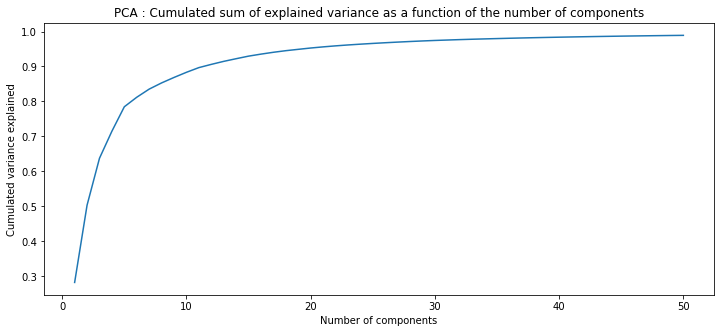

In [15]:
display_pca_variance_cumsum(pca_fitted=pca_std)

In [16]:
X_train_std_pca

array([[ -8.11566998, -19.78188375,  -7.75754504, ...,  -0.87300299,
         -0.36923761,   0.46760814],
       [  6.40704012,   0.17624178, -27.22674717, ...,  -0.2326545 ,
         -0.60749113,   1.13839026],
       [ -8.24169914,  11.53897352, -27.07573884, ...,   1.21051105,
         -0.87708732,  -0.5296454 ],
       ...,
       [ 30.0485468 , -50.36324885,  48.88740903, ...,  -0.16703056,
         -0.54644363,  -0.17542124],
       [ 20.01015394,  15.37328284, -14.7204015 , ...,   1.09683389,
         -0.82625021,   1.85300297],
       [ -3.77412598, -17.1391485 ,  -1.65733898, ...,  -1.10919786,
          0.24232674,  -0.3440817 ]])

In [28]:
pca = PCA(n_components=50)
pca.fit(X_train)
print(pca.explained_variance_ratio_.cumsum())

X_train_pca = pca.transform(X_train)
print("The PCA with 25 components explains", round(pca.explained_variance_ratio_.cumsum()[25], 3) * 100, "% of the variance.")

X_val_pca = pca.transform(X_val)
X_test_pca = pca.transform(X_test)

[0.39197405 0.56966769 0.70709258 0.76118286 0.80864077 0.83682792
 0.86065471 0.8779057  0.89182176 0.90431961 0.91444966 0.92336506
 0.93066943 0.9375993  0.94353076 0.94870892 0.95287837 0.95683576
 0.95997844 0.9629309  0.96552147 0.96774861 0.96971035 0.9714916
 0.97323839 0.97480962 0.97623183 0.97764256 0.97892971 0.98011309
 0.981108   0.98204318 0.98287672 0.98369384 0.98443613 0.98511864
 0.98577158 0.98641729 0.98698854 0.98752371 0.98804309 0.98853282
 0.98898663 0.98940161 0.9897892  0.99016113 0.99051067 0.99085229
 0.99116952 0.99148168]
The PCA with 25 components explains 97.5 % of the variance.


In [18]:
from sklearn.manifold import TSNE

In [20]:
tsne = TSNE(n_components=2, init='pca', learning_rate='auto')
X_tsne = tsne.fit_transform(X_train_std)


In [24]:
def display_pca_tsne(X_pca, X_tsne):
    """
    :param X_pca:
    :param X_tsne:
    :param cls:
    :return:
    """
    fig = plt.figure(figsize=(12, 5))

    ax = fig.add_subplot(121)  # 1 en ordonnée / 2 en abcs / celle là la premiere
    ax.scatter(x=X_pca[:, 0], y=X_pca[:, 1])  # colorier en fct etiquette deu clusterning
    plt.title("Visualizing clusters with PCA")

    ax = fig.add_subplot(122)  # 1 en ordonnée / 2 en abcs / celle là la premiere
    ax.scatter(x=X_tsne[:, 0], y=X_tsne[:, 1])  # palette=sns.color_palette("hls", n_colors=num_clusters)
    plt.title('Principal Components projection with t-SNE')


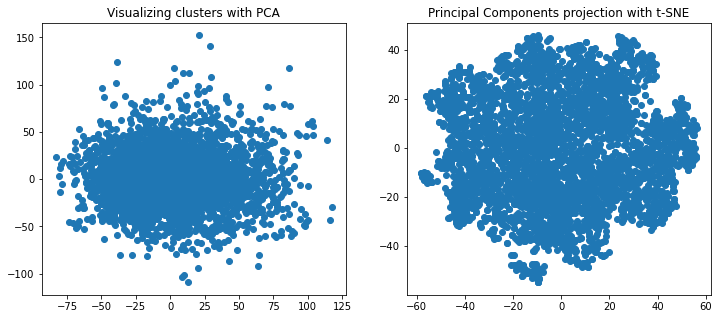

In [25]:
#hierarchical_cls_sample.labels_
display_pca_tsne(X_train_std_pca, X_tsne)

# Part II : Predictive modeling

#### Baseline / Benchmark : Ball Tree

In [8]:
Y_train = pd.read_csv(r"C:\Users\athen\Documents\Scolarité\Alternance\DataChallenge\ChallengeData_CanYouPredictTheTide\dataset\source\Y_train_surge.csv")

surge_train = np.array(Y_train)[:, 1:]
surge_train

array([[ 0.58693592,  1.06958024,  0.76792754, ..., -0.42270688,
        -0.45623606, -0.82505705],
       [ 0.76792754, -0.1001619 ,  0.07077463, ..., -0.82505705,
        -0.99270295, -0.99270295],
       [ 0.07077463, -0.24428486, -0.35489084, ..., -0.99270295,
        -0.32211934, -0.88373311],
       ...,
       [ 0.48303332,  0.53330877,  1.44832196, ...,  1.22022298,
         1.44654495,  2.67036005],
       [ 1.44832196,  1.82036029,  1.66283054, ...,  2.67036005,
         2.62006628,  2.67874235],
       [ 1.66283054,  1.52876268,  1.28408882, ...,  2.67874235,
         1.22022298,  0.72566756]])

In [112]:
# 1) fit
tree = BallTree(X_train.values, metric='l2')

# 2.1) predict
y_val_pred_ballTree = []; k = 40
for i in range(X_val.shape[0]): # 1680 rows
    dist, ind = tree.query([X_val.values[i]], k=k) # X_val from Df to np array
    y_val_pred_ballTree.append(np.mean(surge_train[ind[0]], axis=0)) # we get indexes in surge_train (Y_train) where all the training data is

# 2.2) to matrix
y_val_pred_ballTree = np.array(y_val_pred_ballTree)

# 3) save
save_y_pred("BallTree", output_path, y_val_pred_ballTree, y_val_index, submit=False) # y_val_surge

# 4) evaluate
evaluate_surge(y_pred_filename="Y_val_pred_BallTree.csv", y_true_filename="Y_val_true.csv", path_output=output_path)
display_scatterplot(y_val_true=y_val, y_val_pred=y_val_pred_ballTree)

1.1156099325586981


1.1156099325586981

#### 1) Kernel Ridge

0.6090066039045541


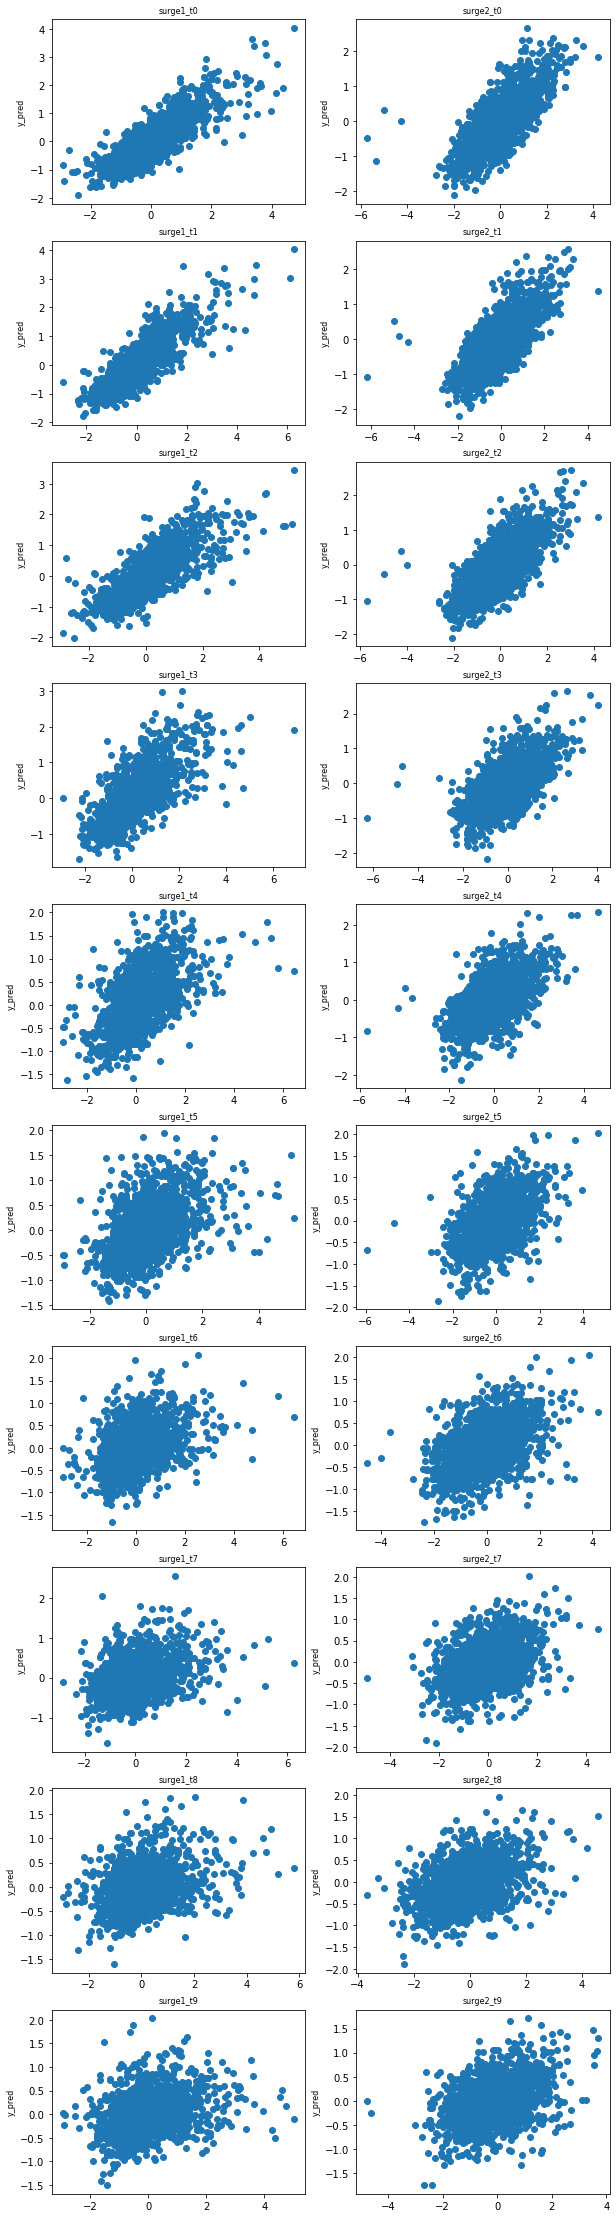

In [75]:
# 1) fit
estimator = KernelRidge(kernel='rbf', alpha=0.372759372031494) # default = Linear
# Valid values for metric are: [‘additive_chi2’, ‘chi2’, ‘linear’, ‘poly’, ‘polynomial’, ‘rbf’, ‘laplacian’, ‘sigmoid’, ‘cosine’]
regr_ridge = MultiOutputRegressor(estimator).fit(X_train_std, y_train) # X_train_std

# 2) save model
path_model = './model/'
dict_models = {'KernelRidge': regr_ridge}
for name, model in dict_models.items():
    filename = path_model + name + '.sav'
    # save the model to disk
    pickle.dump(model, open(filename, 'wb'))

# 3) predict
y_val_surge_pred_ridge = regr_ridge.predict(X_val_std)

# 4) save predictions
save_y_pred("KernelRidge", output_path, y_val_surge_pred_ridge, y_val_index, submit=False)

# 5) evaluate
evaluate_surge(y_pred_filename="Y_val_pred_KernelRidge.csv", y_true_filename="Y_val_true.csv", path_output=output_path)
display_scatterplot(y_val_true=y_val, y_val_pred=y_val_surge_pred_ridge)

In [76]:
# 6) submit
all_models = ["KernelRidge.sav"]
for model_name in all_models:
    filename = './model/' + model_name
    loaded_model = pickle.load(open(filename, 'rb'))

    Y_test_pred = loaded_model.predict(X_test)
    # while saving the model we remove .sav
    save_y_pred(model_name[:-4], output_path + "/submit/", Y_test_pred, X_test_index, submit=True)

In [ ]:
#regr_ridge.predict(X_train.values[[0]])

##### Hyperparameters tuning

##### 1) best alpha

In [77]:
a, b = -4, 4 # default 10**-4
n_alphas = 15  # hyperparametre alpha
alphas = np.logspace(a, b, n_alphas)

regr_KernelRidge = KernelRidge(kernel='rbf')

coefs = []
errors = []

for index, a in enumerate(alphas):
    # 1) fit
    regr_KernelRidge.set_params(alpha=a)
    regr_KernelRidge.fit(X_train_std, y_train)
    # 2) predict
    y_val_surge_pred_KernelRidge = regr_KernelRidge.predict(X_val_std)

    coefs.append(a)

    # 3) save
    save_y_pred("KernelRidge_{}".format(index), output_path, y_val_surge_pred_KernelRidge, y_val_index, submit=False)

    # 4) evaluate
    score_surge = evaluate_surge(y_pred_filename="Y_val_pred_KernelRidge_{}.csv".format(index),
                                 y_true_filename="Y_val_true.csv", path_output=output_path)
    errors.append(score_surge)
    #print(score_surge)

0.7904264984173132
0.7842459164541606
0.7653033610191133
0.7236838730011976
0.6693273761108416
0.62739005365469
0.6096038177715166
0.6156680655872695
0.6426846677912613
0.6924588292268318
0.770310958605962
0.8720413440468915
0.977217198638823
1.040198502940785
1.0638307720514049


Minimum Mean Squared Error for Ridge Regression : 0.6096038177715166
Best alpha for that minimal MSE :  0.2682695795279725


(3.9810717055349695e-05,
 25118.864315095823,
 0.5868924700575222,
 1.0865421197653993)

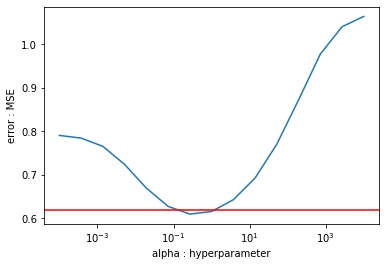

In [78]:
# recupere l'erreur min
print("Minimum Mean Squared Error for Ridge Regression :", errors[np.argmin(errors)])
print("Best alpha for that minimal MSE : ", alphas[np.argmin(errors)])

#Observation of the error behaviour
ax = plt.gca()
ax.plot(alphas, errors)
# specifying horizontal line type
plt.axhline(y=baseline_error, color='r', linestyle='-')

ax.set_xscale('log')

plt.xlabel('alpha : hyperparameter')
plt.ylabel('error : MSE')
plt.axis('tight')

##### 2) best alpha in a smaller range

In [120]:
a, b = -1, 1 # default 10**-4
n_alphas = 15  # hyperparametre alpha
alphas = np.logspace(a, b, n_alphas)

regr_KernelRidge = KernelRidge(kernel='rbf')

coefs = []
errors = []

for index, a in enumerate(alphas):
    # 1) fit
    regr_KernelRidge.set_params(alpha=a)
    regr_KernelRidge.fit(X_train, y_train)
    # 2) predict
    y_val_surge_pred_KernelRidge = regr_KernelRidge.predict(X_val)

    coefs.append(a)

    # 3) save
    save_y_pred("KernelRidge_{}".format(index), output_path, y_val_surge_pred_KernelRidge, y_val_index, submit=False)

    # 4) evaluate
    score_surge = evaluate_surge(y_pred_filename="Y_val_pred_KernelRidge_{}.csv".format(index),
                                 y_true_filename="Y_val_true.csv", path_output=output_path)
    errors.append(score_surge)
    #print(score_surge)

0.6205756763729977
0.6153497822751309
0.6117028952346606
0.6096038177715168
0.6090066039045539
0.6098563504664689
0.6120951278864282
0.6156680655872695
0.6205292600243855
0.626648655659247
0.6340221380166919
0.6426846677912614
0.6527206713745253
0.6642616370029347
0.6774626953109812


Minimum Mean Squared Error for Ridge Regression : 0.6090066039045539
Best alpha for that minimal MSE :  0.372759372031494


(0.07943282347242814,
 12.589254117941675,
 0.6055837993342325,
 0.6808854998813026)

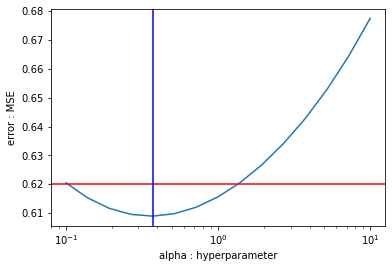

In [122]:
# recupere l'erreur min
print("Minimum Mean Squared Error for Ridge Regression :", errors[np.argmin(errors)])
print("Best alpha for that minimal MSE : ", alphas[np.argmin(errors)])

#Observation of the error behaviour
ax = plt.gca()
ax.plot(alphas, errors)
# specifying horizontal line type
plt.axhline(y=baseline_error, color='r', linestyle='-')


# line with alpha associated to the min error
min_alpha = alphas[np.argmin(errors)]
plt.axvline(x=min_alpha, color='b', label='axvline - full height')

ax.set_xscale('log')

plt.xlabel('alpha : hyperparameter')
plt.ylabel('error : MSE')
plt.axis('tight')

#### 2) XGBoost

0.7457410890788925


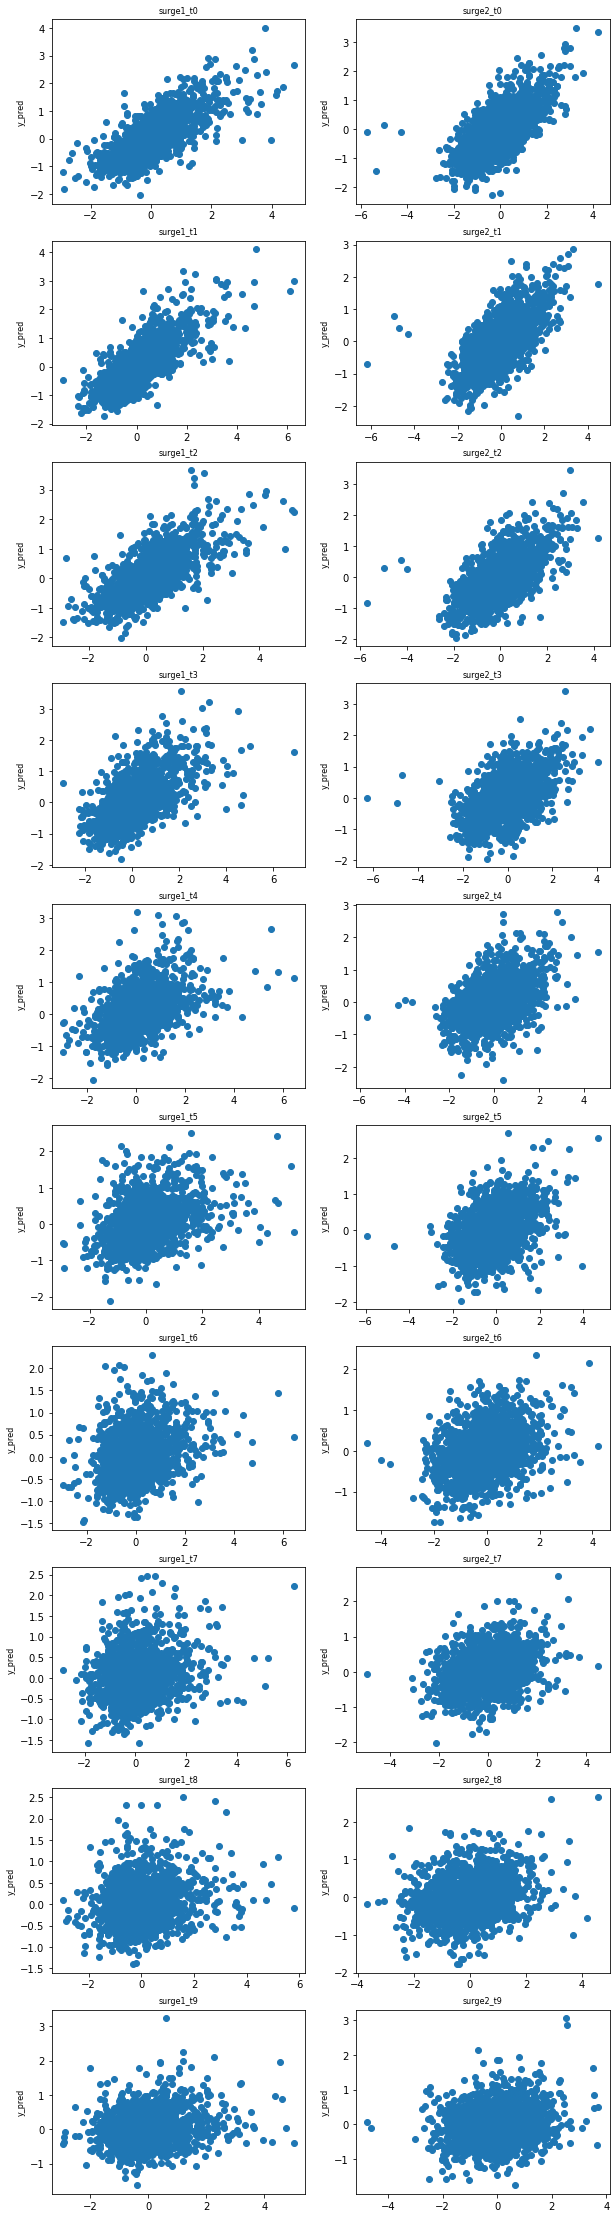

In [79]:
# 1) fit
estimator = XGBRegressor(random_state=seed)
regr_XGBoost = MultiOutputRegressor(estimator).fit(X_train_std_pca, y_train)

# 2) predict
y_val_surge_pred_XGBoost = regr_XGBoost.predict(X_val_std_pca)

# 3) save
save_y_pred("XGBoost", output_path, y_val_surge_pred_XGBoost, y_val_index, submit=False)

# 4) evaluate
evaluate_surge(y_pred_filename="Y_val_pred_XGBoost.csv", y_true_filename="Y_val_true.csv", path_output=output_path)
display_scatterplot(y_val_true=y_val, y_val_pred=y_val_surge_pred_XGBoost)

#### 3) SVR : 0.62 without tuning without scaling => 0.72 for Y_test

0.6254030537774797


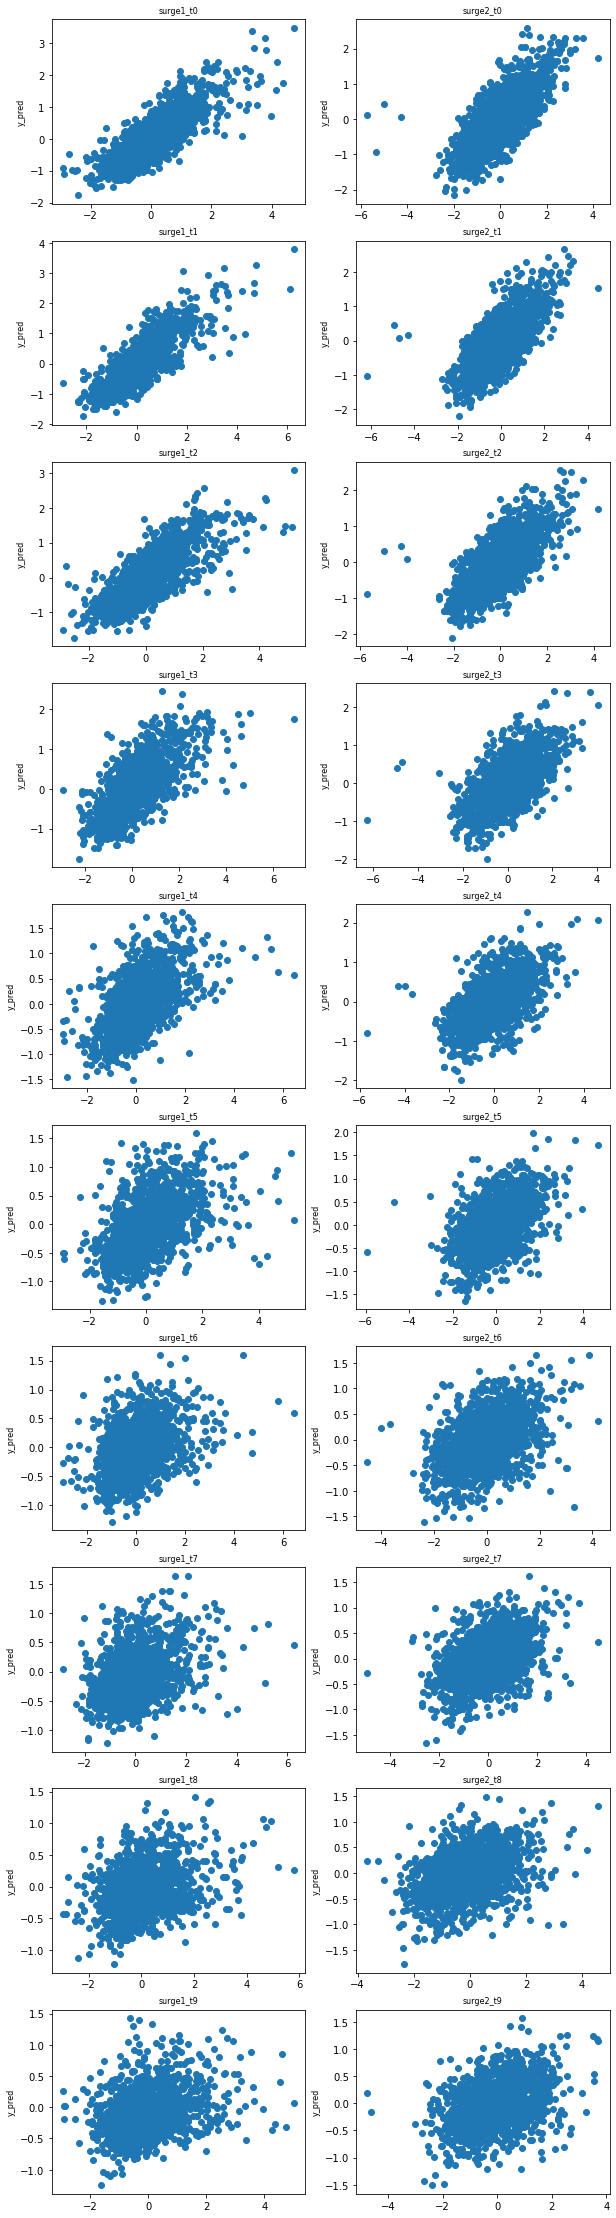

In [80]:
# 1) fit
estimator = SVR(kernel='rbf')

#from tqdm import tqdm
regr_SVR = MultiOutputRegressor(estimator).fit(X_train_std_pca, y_train)

# 2) save model
path_model = './model/'
dict_models = {'SVR': regr_SVR}
for name, model in dict_models.items():
    filename = path_model + name + '.sav'
    # save the model to disk
    pickle.dump(model, open(filename, 'wb'))

# 3) predict
y_val_surge_pred_SVR = regr_SVR.predict(X_val_std_pca)

# 4) save predictions
save_y_pred("SVR", output_path, y_val_surge_pred_SVR, y_val_index, submit=False)

# 5) evaluate
evaluate_surge(y_pred_filename="Y_val_pred_SVR.csv", y_true_filename="Y_val_true.csv", path_output=output_path)
display_scatterplot(y_val_true=y_val, y_val_pred=y_val_surge_pred_SVR)


In [11]:
# 6) submit
all_models = ["SVR.sav"]
for model_name in all_models:
    filename = './model/' + model_name
    loaded_model = pickle.load(open(filename, 'rb'))

    Y_test_pred = loaded_model.predict(X_test)
    # while saving the model we remove .sav
    save_y_pred(model_name[:-4], output_path + "/submit/", Y_test_pred, X_test_index, submit=True)

##### Tuning

In [81]:
from sklearn.model_selection import GridSearchCV

parameters = {'gamma' : [1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1], #kernel coefficient [ici kernel = Radial Basis Function]
              'epsilon' : [0.001, 0.01, 0.1, 1], #erreur tolérée par l'algorithme
              'C' : [0.001, 0.01, 0.1, 1, 10]} #parametre de régularisation


estimator = SVR(kernel='rbf')
grid_multi_SVR = GridSearchCV(
    estimator=MultiOutputRegressor(estimator),
    param_grid=parameters,
    cv=5,
    verbose=0)

grid_multi_SVR.fit(X_train_std_pca, y_train)



ValueError: Invalid parameter 'C' for estimator MultiOutputRegressor(estimator=SVR()). Valid parameters are: ['estimator', 'n_jobs'].

In [ ]:
# best estimator
print("Best estimator :", grid_multi_SVR.best_estimator_)

# best model
best_model = grid_multi_SVR.best_estimator_

# 1) fit
best_model.fit(X_train, y_train)

# 2) predict
y_val_surge_pred_grid_SVR = best_model.predict(X_val)

# 3) save predictions
save_y_pred("grid_SVR", output_path, y_val_surge_pred_grid_SVR, y_val_index, submit=False)

# 4) evaluate
evaluate_surge(y_pred_filename="Y_val_pred_grid_SVR.csv", y_true_filename="Y_val_true.csv", path_output=output_path)

#### 4) Random Forest : needs pca indeed mdrr

In [83]:
# 1) fit
estimator = RandomForestRegressor(n_estimators=100, random_state=seed)
regr_RFR = MultiOutputRegressor(estimator).fit(X_train_std_pca, y_train)

# 2) predict
y_val_surge_pred_RFR = regr_RFR.predict(X_val_std_pca)

# 3) save
save_y_pred("RFR", output_path, y_val_surge_pred_RFR, y_val_index, submit=False)

# 4) evaluate
evaluate_surge(y_pred_filename="Y_val_pred_RFR.csv", y_true_filename="Y_val_true.csv", path_output=output_path)

0.6939966490827575


0.6939966490827575

#### 5) NN : MLP Regressor : supports Multi-outputs

0.6230660275460845


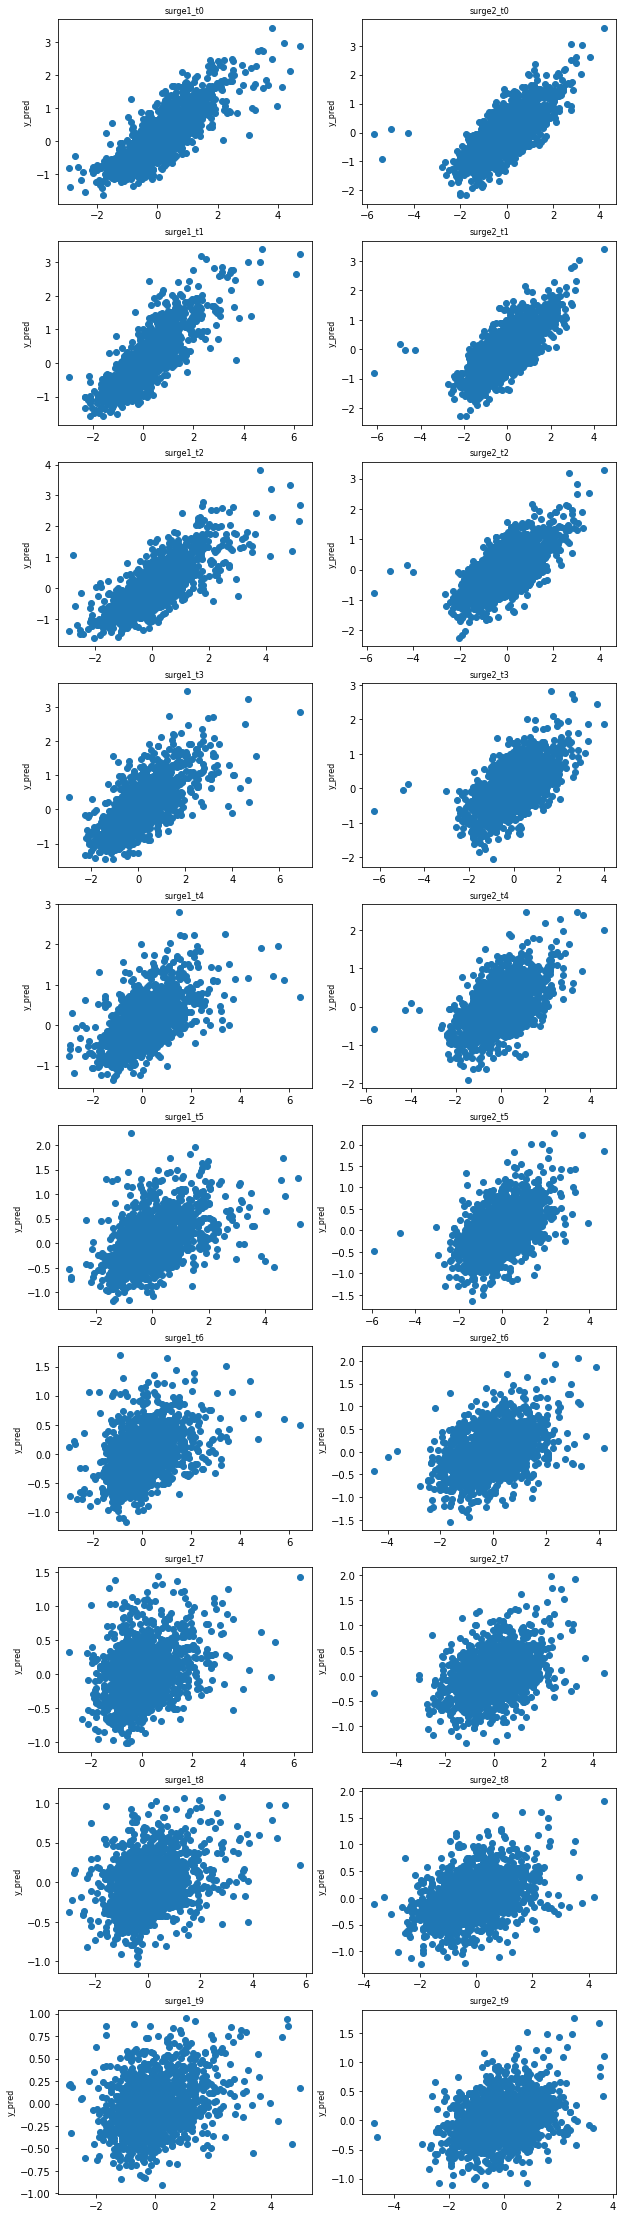

In [38]:
# 1) fit / alpha=10**2
regr_MLPR = MLPRegressor(random_state=seed, max_iter=500, alpha=71.96856730011514).fit(X_train_std_pca, y_train)

# 2) save model
path_model = './model/'
dict_models = {'MLPR': regr_MLPR}
for name, model in dict_models.items():
    filename = path_model + name + '.sav'
    # save the model to disk
    pickle.dump(model, open(filename, 'wb'))

# 3) predict
y_val_surge_pred_MLR = regr_MLPR.predict(X_val_std_pca)

# 4) save
save_y_pred("MLPR", output_path, y_val_surge_pred_MLR, y_val_index, submit=False)

# 5) evaluate
evaluate_surge(y_pred_filename="Y_val_pred_MLPR.csv", y_true_filename="Y_val_true.csv", path_output=output_path)
display_scatterplot(y_val_true=y_val, y_val_pred=y_val_surge_pred_MLR)

In [86]:
# 6) submit
all_models = ["MLPR.sav"]
for model_name in all_models:
    filename = './model/' + model_name
    loaded_model = pickle.load(open(filename, 'rb'))

    Y_test_pred = loaded_model.predict(X_test_std_pca)
    # while saving the model we remove .sav
    save_y_pred(model_name[:-4], output_path + "/submit/", Y_test_pred, X_test_index, submit=True)

##### Hyperparameters tuning

In [34]:
a, b = -5, 3 # default 10**-4
n_alphas = 15 # hyperparametre alpha
alphas = np.logspace(a, b, n_alphas)

regr_MLR = MLPRegressor(random_state=seed, max_iter=500)

coefs = []
errors = []

for index, a in enumerate(alphas):
    # 1) fit
    regr_MLR.set_params(alpha=a)
    regr_MLR.fit(X_train_std_pca, y_train)
    # 2) predict
    y_val_surge_pred_MLR = regr_MLR.predict(X_val_std_pca)

    coefs.append(a)

    # 3) save
    save_y_pred("MLR_{}".format(index), output_path, y_val_surge_pred_MLR, y_val_index, submit=False)

    # 4) evaluate
    score_surge = evaluate_surge(y_pred_filename="Y_val_pred_MLR_{}.csv".format(index), y_true_filename="Y_val_true.csv", path_output=output_path)
    errors.append(score_surge)
    #print(score_surge)

0.8721074780568814
0.8524732491230556
0.886653580335699
0.8522095601807089
0.8253418298938537
0.908812915253052
0.8862161608625896
0.8007733533757053
0.7654551910482257
0.6920624160313295
0.6633313213884198
0.6384895866282034
0.6230660275460845
0.6607610877003469
0.7351826185538575


Minimum Mean Squared Error for MLP : 0.6230660275460845
Best alpha for that minimal MSE :  71.96856730011514


(3.981071705534969e-06,
 2511.88643150958,
 0.6055593542373474,
 0.9232535610157045)

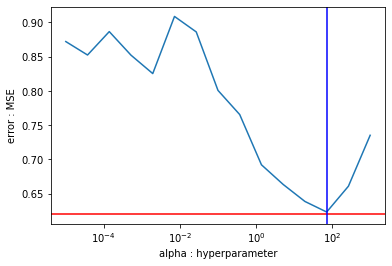

In [37]:
# recupere l'erreur min
print("Minimum Mean Squared Error for MLP :", errors[np.argmin(errors)])
print("Best alpha for that minimal MSE : ", alphas[np.argmin(errors)])

#Observation of the error behaviour
ax = plt.gca()
ax.plot(alphas, errors)
# specifying horizontal line type
plt.axhline(y=baseline_error, color='r', linestyle='-')

# line with alpha associated to the min error
min_alpha = alphas[np.argmin(errors)]
plt.axvline(x=min_alpha, color='b', label='axvline - full height')

ax.set_xscale('log')

plt.xlabel('alpha : hyperparameter')
plt.ylabel('error : MSE')
plt.axis('tight')

## Neural Networks : https://www.nature.com/articles/s41598-021-96674-0
1) Artificial Neural Network (ANN)
2) a Long Term Short Term Neural Network (LSTM)
3) a Convolutional Neural Network (CNN)
4) a Convolutional LSTM (ConvLSTM), which is a combination of the latter two. In

(5599, 3362)
(5599, 20)


In [19]:
#The LSTM model input dimension requires the third dimension that will be the number of the single input row. We'll reshape the x data.

print(X_train.shape)
print(y_train.shape)

X_train_NN = X_train.values.reshape(X_train.shape[0], X_train.shape[1], 1)
X_val_NN = X_val.values.reshape(X_val.shape[0], X_val.shape[1], 1)

print("X_train:", X_train_NN.shape, "y_train:", y_train.shape)

(3919, 3362)
(3919, 20)
X_train: (3919, 3362, 1) y_train: (3919, 20)


In [22]:
in_dim = (X_train_NN.shape[1], X_train_NN.shape[2])
out_dim = y_train.shape[1]

print(in_dim)
print(out_dim)

(3362, 1)
20


We'll start by defining the sequential model. The sequential model contains LSTM layers with ReLU activations, Dense output layer,  and Adam optimizer with MSE loss function. We'll set the input dimension in the first layer and output dimension in the last layer of the model.

In [ ]:
# 2) save model
path_model = './model/'
dict_models = {'LSTM': model}
for name, model in dict_models.items():
    filename = path_model + name + '.sav'
    # save the model to disk
    pickle.dump(model, open(filename, 'wb'))

In [ ]:
y_pred = model.predict(X_val_NN)

print("y1 MSE:%.4f" % mean_squared_error(y_val[:,0], y_pred[:,0]))
print("y2 MSE:%.4f" % mean_squared_error(y_val[:,1], y_pred[:,1]))


In [ ]:
# 4) save
save_y_pred("LSTM", output_path, y_pred, y_val_index, submit=False)

# 5) evaluate
evaluate_surge(y_pred_filename="Y_val_pred_LSTM.csv", y_true_filename="Y_val_true.csv", path_output=output_path)

In [ ]:
y_pred

#### Saving models

In [ ]:
dict_models = {
    'KernelRidge': regr_ridge,
    'XGBoost': regr_XGBoost,
    'SVR': regr_SVR,
    'MLPR': regr_MLPR
}
#    'BallTree': tree, # no predict method

In [ ]:
path_model = './model/'
for name, model in dict_models.items():
    filename = path_model + name + '.sav'
    # save the model to disk
    pickle.dump(model, open(filename, 'wb'))

# Part III : Submission prediction

#### Predicting Y_test for each model using models trained using split X_train

In [ ]:
# load the model from disk
all_models = [f for f in listdir(path_model) if isfile(join(path_model, f))]

for model_name in all_models:
    filename = './model/' + model_name
    loaded_model = pickle.load(open(filename, 'rb'))

    Y_test_pred = loaded_model.predict(X_test)
    # while saving the model we remove .sav
    save_y_pred(model_name[:-4], output_path + "/submit/", Y_test_pred, X_test_index, submit=True)

#### Predicting Y_test for the best model using all of X_train to train : no gain for XGBoost / SVR ?

In [15]:
best_estimator = KernelRidge(alpha=0.372759372031494)#SVR(kernel='rbf')
best_regr = MultiOutputRegressor(best_estimator).fit(X_train, y_train)

name, model = "best_model", best_regr
path_model = "./model/"
filename = path_model + name + '.sav'
# save the model to disk
pickle.dump(model, open(filename, 'wb'))

In [16]:
model_name = "best_model"
filename = './model/' + model_name + ".sav"

loaded_best_model = pickle.load(open(filename, 'rb'))
Y_test_pred = loaded_best_model.predict(X_test)
save_y_pred(model_name, output_path + "/submit/", Y_test_pred, X_test_index, submit=True)

In [17]:
evaluate_surge(y_pred_filename="Y_test_pred_best_model.csv", y_true_filename="Y_test_pred_KernelRidge.csv", path_output=output_path + "/submit/")

0.23704137451911803


0.23704137451911803

###  End of notebook

In [ ]:
# End of pipeline time
t1 = time()
print("computing time : {:8.6f} sec".format(t1 - t0))
print("computing time : " + strftime('%H:%M:%S', gmtime(t1 - t0)))